In [1]:
#all imports here..
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#import plotly.express as px

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc, roc_auc_score, mutual_info_score

import warnings
warnings.filterwarnings("ignore")

%xmode Minimal
%matplotlib notebook

Exception reporting mode: Minimal


In [ ]:
data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv'

In [ ]:
!wget $data

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [ ]:
df.shape

In [ ]:
df.head().T

formatting to lowercase columns' titles and values

In [3]:
'''
a = 'asdDas'
b=re.sub(r'([a-z])([A-Z])', r'\1_\2', a)
b     #b = 'asd_das'
'''

df.columns = df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()

In [4]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['month', 'visitor_type']

In [5]:
for col in strings:
    df[col] = df[col].str.lower()

In [ ]:
df.info()

<li>there are no missing values.</li>
<li>administrative, informational and product_related are number of pages</li>
<li>operating_system, browser, region, traffic_type are formatted as int64 but can be considered as categorical (they have no ordinal meaning)</li>

In [ ]:
df.describe().round()  #this is limited to the 14 numeric features (object and bool dtypes excluded)

In [ ]:
for col in df.columns:
    print('column name: ',col)
    #print(df[col].unique()[:5])
    print('data type: ', df[col].dtype)
    print('nbr. of unique values: ',df[col].nunique())
    print()

In [ ]:
import sys
!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report")

#profile.to_widgets()
profile.to_notebook_iframe()

In [ ]:
plt.figure(figsize=(15,10))  
sns.heatmap(df.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [6]:
target_name = 'revenue'  #True if session ended in a buy

data, target = df.drop(columns=target_name), df[target_name]
target = (target == True).astype(int)

In [ ]:
#target.unique()
target.shape

In [ ]:
data.columns

In [7]:
#data['weekend'] = data['weekend'].astype(int)

numeric_features = ['administrative', 'administrative_duration', 'informational',
       'informational_duration', 'product_related', 'product_related_duration',
       'bounce_rates', 'exit_rates', 'page_values', 'special_day']

data['operating_systems'] = data['operating_systems'].astype(str)
data['browser'] = data['browser'].astype(str)
data['region'] = data['region'].astype(str)
data['traffic_type'] = data['traffic_type'].astype(str)

'''
categorical_features = ['month',
       'operating_systems', 'browser', 'region', 'traffic_type',
       'visitor_type']
'''
categorical_features = list(data.dtypes[data.dtypes == 'object'].index)

boolean_features = ['weekend']


data = data[numeric_features + categorical_features + boolean_features]


data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            12330 non-null  int64  
 1   administrative_duration   12330 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    12330 non-null  float64
 4   product_related           12330 non-null  int64  
 5   product_related_duration  12330 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   special_day               12330 non-null  float64
 10  month                     12330 non-null  object 
 11  operating_systems         12330 non-null  object 
 12  browser                   12330 non-null  object 
 13  region                    12330 non-null  object 
 14  traffi

In [8]:
#treating outliers in numeric features by normalizing with RobustScaler

feature_names = list(data[numeric_features].columns)
#feature_names

X = data[numeric_features].to_numpy()
X[:5,:]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 2.00000000e-01, 2.00000000e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.00000000e+00, 6.40000000e+01, 0.00000000e+00, 1.00000000e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 2.00000000e-01, 2.00000000e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.00000000e+00, 2.66666667e+00, 5.00000000e-02, 1.40000000e-01,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+01, 6.27500000e+02, 2.00000000e-02, 5.00000000e-02,
        0.00000000e+00, 0.00000000e+00]])

In [9]:
norm_data_arr = RobustScaler(quantile_range=(25, 75)).fit_transform(X)

In [ ]:
norm_data_arr[:5,:]

In [10]:
norm_data = pd.DataFrame(norm_data_arr, columns = feature_names)
norm_data.head()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day
0,-0.25,-0.080424,0.0,0.0,-0.548387,-0.467912,11.710742,4.895621,0.0,0.0
1,-0.25,-0.080424,0.0,0.0,-0.516129,-0.417913,-0.185128,2.095621,0.0,0.0
2,-0.25,-0.080424,0.0,0.0,-0.548387,-0.467912,11.710742,4.895621,0.0,0.0
3,-0.25,-0.080424,0.0,0.0,-0.516129,-0.465829,2.788840,3.215621,0.0,0.0
4,-0.25,-0.080424,0.0,0.0,-0.258065,0.022315,1.004459,0.695621,0.0,0.0


In [11]:
df_preproc = pd.concat([norm_data, data[categorical_features], data[boolean_features], target], axis = 1)
df_preproc.head()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,-0.25,-0.080424,0.0,0.0,-0.548387,-0.467912,11.710742,4.895621,0.0,0.0,feb,1,1,1,1,returning_visitor,False,0
1,-0.25,-0.080424,0.0,0.0,-0.516129,-0.417913,-0.185128,2.095621,0.0,0.0,feb,2,2,1,2,returning_visitor,False,0
2,-0.25,-0.080424,0.0,0.0,-0.548387,-0.467912,11.710742,4.895621,0.0,0.0,feb,4,1,9,3,returning_visitor,False,0
3,-0.25,-0.080424,0.0,0.0,-0.516129,-0.465829,2.788840,3.215621,0.0,0.0,feb,3,2,2,4,returning_visitor,False,0
4,-0.25,-0.080424,0.0,0.0,-0.258065,0.022315,1.004459,0.695621,0.0,0.0,feb,3,3,1,4,returning_visitor,True,0


In [ ]:
profile2 = ProfileReport(df_preproc, title="Pandas Profiling Report")

#profile2.to_widgets()
profile2.to_notebook_iframe()

In [12]:
#preparing for evaluation of first model..

df_full_train, df_test = train_test_split(df_preproc, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.revenue.values
y_val = df_val.revenue.values
y_test = df_test.revenue.values

del df_train['revenue']
del df_val['revenue']
del df_test['revenue']

In [13]:
df_train.shape, df_val.shape, df_test.shape

((7398, 17), (2466, 17), (2466, 17))

**first experiment: 2 models (LR and RF), no hyperparam tuning, no cross_val**

In [34]:
#one hot encoding of categorical features
dv = DictVectorizer(sparse=False)

train_dict = df_train[numeric_features + categorical_features + boolean_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [24]:
X_train.shape

(7398, 72)

In [75]:
dv.feature_names_

['administrative',
 'administrative_duration',
 'bounce_rates',
 'browser=1',
 'browser=10',
 'browser=11',
 'browser=12',
 'browser=13',
 'browser=2',
 'browser=3',
 'browser=4',
 'browser=5',
 'browser=6',
 'browser=7',
 'browser=8',
 'exit_rates',
 'informational',
 'informational_duration',
 'month=aug',
 'month=dec',
 'month=feb',
 'month=jul',
 'month=june',
 'month=mar',
 'month=may',
 'month=nov',
 'month=oct',
 'month=sep',
 'operating_systems=1',
 'operating_systems=2',
 'operating_systems=3',
 'operating_systems=4',
 'operating_systems=5',
 'operating_systems=6',
 'operating_systems=7',
 'operating_systems=8',
 'page_values',
 'product_related',
 'product_related_duration',
 'region=1',
 'region=2',
 'region=3',
 'region=4',
 'region=5',
 'region=6',
 'region=7',
 'region=8',
 'region=9',
 'special_day',
 'traffic_type=1',
 'traffic_type=10',
 'traffic_type=11',
 'traffic_type=13',
 'traffic_type=14',
 'traffic_type=15',
 'traffic_type=16',
 'traffic_type=17',
 'traffic_type

In [37]:
val_dict = df_val[numeric_features + categorical_features + boolean_features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [27]:
# first model is LogisticRegression()
model = LogisticRegression(random_state=1)
model.fit(X_train, y_train)

LogisticRegression()

In [28]:
y_pred = model.predict_proba(X_val)[:, 1]
realized_revenue = (y_pred >= 0.5)

In [29]:
#accuracy of the LogisticRegression() model
(y_val == realized_revenue).mean()

0.8828061638280617

In [30]:
#accuracy of the dummy model, which decides always in favour of the majority class (in this case the class revenue == 0)
1 - y_val.mean()  

0.8418491484184915

In [32]:
#calculating false_pos, t_pos for different threshold
fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred)

In [ ]:
#ROC curve for the first model

plt.figure(figsize=(5, 5))

plt.plot(fpr1, tpr1, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [33]:
#AUC metric
auc(fpr1, tpr1)

0.8941443110518255

In [34]:
#ROC-AUC score
roc_auc_score(y_val, y_pred)

0.8941443110518255

In [ ]:
#ROC-AUC score for evaluation of feature importance

feat_list = []

for c in numeric_features:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
#    print('%9s, %.3f' % (c, auc))
    feat_list.append((c, auc))

sorted(feat_list, key=lambda tup: tup[1], reverse=True)

In [ ]:
#calculating mutual information to assess feature importance of categorical features

def calculate_mi(series):
    return mutual_info_score(series, y_train)

#@ IMPLEMENTATION:
df_mi = df_train[categorical_features].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

In [92]:
#the second model is RandomForestClassifier()

rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [93]:
y_pred = rf.predict_proba(X_val)[:, 1]
realized_revenue = (y_pred >= 0.5)

In [94]:
#accuracy of the RandomForestClassifier() model
(y_val == realized_revenue).mean()

0.8982157339821574

In [95]:
fpr2, tpr2, thresholds2 = roc_curve(y_val, y_pred)

#AUC metric
auc(fpr2, tpr2)

0.9315158589002519

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(fpr1, tpr1, label='Model 1 - lr')
plt.plot(fpr2, tpr2, label='Model 2 - rf')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

**second experiment: estimating generalization error via nested cross_val. Note that nested cross-val is suited for small datasets like our that is under 10000 rows**

In [14]:
#because we are going to use cross-val there is no need to separate train and val

df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.revenue.values
del df_full_train['revenue']

In [15]:
df_full_train.shape

(9864, 17)

In [76]:
#one hot encoding of categorical features (non need of separated train and val, in view of cross-validation)
dv = DictVectorizer(sparse=False)

train_dict = df_full_train[numeric_features + categorical_features + boolean_features].to_dict(orient='records')
X_full_train = dv.fit_transform(train_dict)

In [77]:
X_full_train.shape

(9864, 74)

In [79]:
dv.feature_names_

['administrative',
 'administrative_duration',
 'bounce_rates',
 'browser=1',
 'browser=10',
 'browser=11',
 'browser=12',
 'browser=13',
 'browser=2',
 'browser=3',
 'browser=4',
 'browser=5',
 'browser=6',
 'browser=7',
 'browser=8',
 'browser=9',
 'exit_rates',
 'informational',
 'informational_duration',
 'month=aug',
 'month=dec',
 'month=feb',
 'month=jul',
 'month=june',
 'month=mar',
 'month=may',
 'month=nov',
 'month=oct',
 'month=sep',
 'operating_systems=1',
 'operating_systems=2',
 'operating_systems=3',
 'operating_systems=4',
 'operating_systems=5',
 'operating_systems=6',
 'operating_systems=7',
 'operating_systems=8',
 'page_values',
 'product_related',
 'product_related_duration',
 'region=1',
 'region=2',
 'region=3',
 'region=4',
 'region=5',
 'region=6',
 'region=7',
 'region=8',
 'region=9',
 'special_day',
 'traffic_type=1',
 'traffic_type=10',
 'traffic_type=11',
 'traffic_type=12',
 'traffic_type=13',
 'traffic_type=14',
 'traffic_type=15',
 'traffic_type=16',


In [22]:
model_cv = LogisticRegression(solver = 'lbfgs', max_iter = 10_000, 
                              random_state=1)

In [23]:
param_grid = [{
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]}]

In [24]:
# Making a Grid Search for selecting model by hyperparameter tuning, using
# 2-fold StratifiedKFold cross validation

gs = GridSearchCV(estimator=model_cv, param_grid = param_grid,
                 cv = 2, scoring = 'roc_auc')

In [25]:
#(nested) cross validation ( 5 x 2 cross-val: inner = 5 folds, outer = 2 folds). Outer is in the cell above..
scores = cross_val_score(gs, X_full_train, y_full_train, scoring='roc_auc', cv=5, error_score='raise')

# mean scores and standard deviation
print('CV auc_roc: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV auc_roc: 0.900 +/- 0.006


In [58]:
#second model is RandomForestClassifier()
model2_cv = RandomForestClassifier(random_state=1)

In [64]:
param_grid = [{
    'max_depth': [10, 15, 20],
    'n_estimators' : [100, 200, 500],
    'min_samples_leaf': [1, 3, 5, 10]}]

In [65]:
gs = GridSearchCV(estimator=model2_cv, param_grid = param_grid,
                 cv = 2, scoring = 'roc_auc')

In [66]:
scores = cross_val_score(gs, X_full_train, y_full_train, scoring='roc_auc', cv=5, error_score='raise')

print('CV auc_roc: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV auc_roc: 0.927 +/- 0.007


**Selecting the final model to use in deployment**

after having calculated a robust estimate of the generalization errors of the models, we continue with the better one (RandomForestClassifier), to find his optimal hyperparameters values by means of gridSearchCV, then we will define the best model to export to train.py for the deployment part

In [67]:
gs.fit(X_full_train, y_full_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=1),
             param_grid=[{'max_depth': [10, 15, 20],
                          'min_samples_leaf': [1, 3, 5, 10],
                          'n_estimators': [100, 200, 500]}],
             scoring='roc_auc')

In [68]:
gs.best_params_

{'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 500}

In [69]:
final_model = RandomForestClassifier(max_depth = 15, n_estimators = 500,
                                    min_samples_leaf = 3, random_state = 1)

In [80]:
final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=500,
                       random_state=1)

In [81]:
test_val = df_val[numeric_features + categorical_features + boolean_features].to_dict(orient='records')
X_test = dv.transform(val_dict)

In [83]:
y_pred = final_model.predict_proba(X_val)[:,1]

In [84]:
realized_revenue = (y_pred >= 0.5)

In [85]:
#accuracy of the RandomForestClassifier() model
(y_val == realized_revenue).mean()

0.8998377939983779

In [88]:
fpr3, tpr3, thresholds3 = roc_curve(y_val, y_pred)

In [89]:
#AUC metric
auc(fpr3, tpr3)

0.9368805889037103

<IPython.core.display.Javascript object>


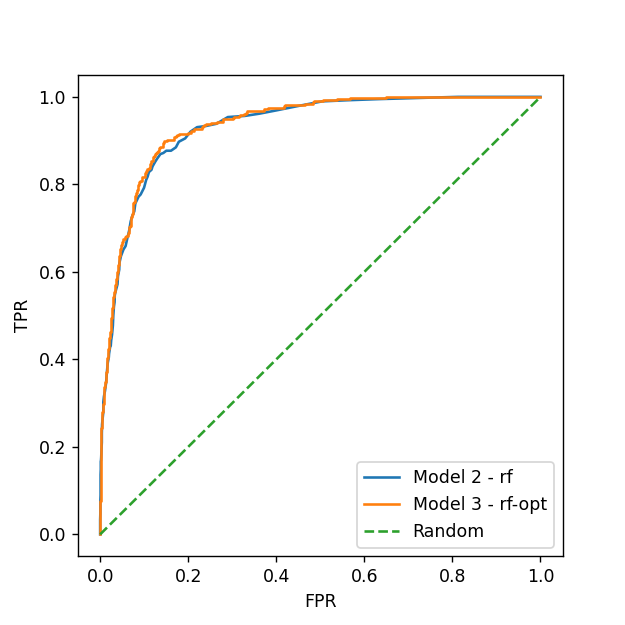

In [96]:
plt.figure(figsize=(5, 5))

plt.plot(fpr2, tpr2, label='Model 2 - rf')
plt.plot(fpr3, tpr3, label='Model 3 - rf-opt')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()